In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/insurance/insurance.csv


In [2]:
import pandas as pd
import numpy as np
np.set_printoptions(suppress=True)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.metrics import mean_squared_error, r2_score
from zipfile import ZipFile
import warnings
warnings.filterwarnings('ignore')


In [3]:
data = pd.read_csv("/kaggle/input/insurance/insurance.csv")
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [4]:
n, m = data.shape
print(f"Number of columns: {m} columns\nNumber of rows: {n} rows")

Number of columns: 7 columns
Number of rows: 1338 rows


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [6]:
data.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [7]:
data.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


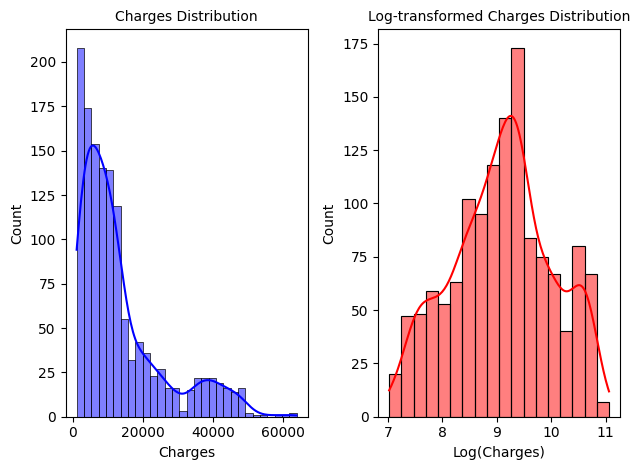

In [8]:
fig = plt.figure()
plt.subplot(121)
sns.histplot(data['charges'], kde=True, color='blue')
plt.title('Charges Distribution', size=10)
plt.xlabel('Charges')

plt.subplot(122)
sns.histplot(np.log(data['charges']), kde=True, color='red')
plt.title('Log-transformed Charges Distribution', size=10)
plt.xlabel('Log(Charges)')
plt.tight_layout()
plt.show()

<Axes: >

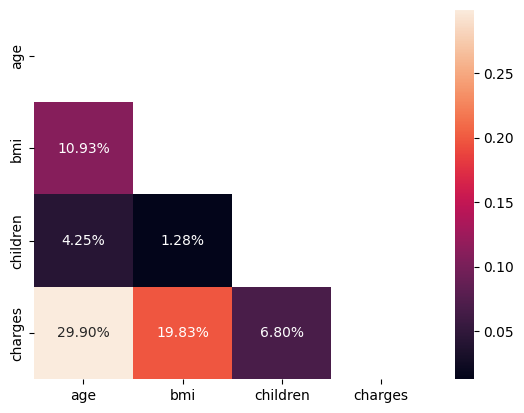

In [9]:
corr = data.corr(numeric_only=True)
mask = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(corr, mask=mask, annot=True, fmt=".2%")

In [10]:
data["age group"] = pd.cut(data.age, bins=[0, 40, 60, 100], labels=["young adult", "middle-aged", "old adults"])
data.groupby("age group")["charges"].agg(["mean", "count"])

,mean,count
age group,,
young adult,10219.422874,701
middle-aged,15888.757668,546
old adults,21063.163398,91


In [11]:
data.groupby("smoker")["charges"].agg(["mean", "count"])

,mean,count
smoker,,
no,8434.268298,1064
yes,32050.231832,274


In [13]:
X = data.drop(['charges','region'], axis=1)
y = data.charges

X["sex"] = X["sex"].map({"female": 0, "male": 1})
X["smoker"] = X["smoker"].map({"no": 0, "yes": 1})
X["age group"] = X["age group"].map({"young adult": 0, "middle-aged": 1, "old adults": 2})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=23)

In [14]:
def model_pipeline(model, degree=2):
    num_pipeline = Pipeline(steps=[("poly", PolynomialFeatures(degree=degree)),("scaler", StandardScaler())])
    
    transformer = ColumnTransformer([("num_transformers", num_pipeline, make_column_selector(dtype_include="number"))],
                                    remainder="passthrough")

    model_pipeline = Pipeline(steps=[("transformer", transformer), ("model", model)])
    return model_pipeline

In [15]:
kf = KFold(shuffle=True, random_state=42, n_splits=3)


In [16]:
# Gride Search for Linear Regression
lr = model_pipeline(LinearRegression())
lr_grid = {"transformer__num_transformers__poly__degree": range(0, 6)}

grid_search = GridSearchCV(estimator=lr,param_grid=lr_grid,cv=kf,scoring=("r2", "neg_mean_squared_error"),refit="r2")
grid_search.fit(X_train, y_train)
grid_search.best_score_, grid_search.best_params_

(0.8365898707604332, {'transformer__num_transformers__poly__degree': 2})

In [17]:
best_lr = model_pipeline(
    LinearRegression(),
    degree=grid_search.best_params_["transformer__num_transformers__poly__degree"],
)

best_lr.fit(X_train, y_train)
print("Training score", best_lr.score(X_train, y_train))
print("Testing score", best_lr.score(X_test, y_test))

Training score 0.8434586748166498
Testing score 0.8440829135632233


In [20]:
# Lasso regression
lasso = model_pipeline(Lasso())
lasso_grid = {
    "transformer__num_transformers__poly__degree": range(1, 4),
    "model__alpha": np.geomspace(0.01, 10, 20),
    
}

grid_search = GridSearchCV(estimator=lasso, param_grid=lasso_grid, cv=kf, refit="r2")
grid_search.fit(X_train, y_train)
grid_search.best_score_, grid_search.best_params_

(0.8367420057246173,
 {'model__alpha': 4.832930238571752,
  'transformer__num_transformers__poly__degree': 2})

In [21]:
best_l1 = model_pipeline(
    Lasso(alpha=grid_search.best_params_["model__alpha"]),
    degree=grid_search.best_params_["transformer__num_transformers__poly__degree"],
)

best_l1.fit(X_train, y_train)
print("Training score", best_l1.score(X_train, y_train))
print("Testing score", best_l1.score(X_test, y_test))

Training score 0.8433381008969295
Testing score 0.8449299997893385


In [22]:
ridge = model_pipeline(Ridge())
ridge_grid = {
    "transformer__num_transformers__poly__degree": range(1, 4),
    "model__alpha": np.geomspace(0.01, 10, 20),
}

grid_search = GridSearchCV(estimator=ridge, param_grid=ridge_grid, cv=kf, refit="r2")
grid_search.fit(X_train, y_train)
grid_search.best_score_, grid_search.best_params_

(0.8366788077179622,
 {'model__alpha': 0.5455594781168517,
  'transformer__num_transformers__poly__degree': 2})

In [23]:
best_l2 = model_pipeline(
    Ridge(alpha=grid_search.best_params_["model__alpha"]),
    degree=grid_search.best_params_["transformer__num_transformers__poly__degree"],
)

best_l2.fit(X_train, y_train)
print("Training score", best_l2.score(X_train, y_train))
print("Testing score", best_l2.score(X_test, y_test))

Training score 0.8434307633120981
Testing score 0.8441526250026626


In [24]:
elastic_net = model_pipeline(ElasticNet())
elastic_net_grid = {
    "transformer__num_transformers__poly__degree": range(1, 4),
    "model__alpha": np.geomspace(0.01, 10, 20),
    "model__l1_ratio": np.linspace(0.01, 1, 10),
}


grid_search = GridSearchCV(estimator= elastic_net, param_grid=elastic_net_grid, cv=kf, refit="r2")
grid_search.fit(X_train, y_train)
grid_search.best_score_, grid_search.best_params_

(0.8367420057246173,
 {'model__alpha': 4.832930238571752,
  'model__l1_ratio': 1.0,
  'transformer__num_transformers__poly__degree': 2})

In [25]:
best_elastic_net = model_pipeline(ElasticNet(alpha=grid_search.best_params_["model__alpha"], l1_ratio=grid_search.best_params_["model__l1_ratio"]), degree=grid_search.best_params_["transformer__num_transformers__poly__degree"])
best_elastic_net.fit(X_train, y_train)
print("Training score", best_elastic_net.score(X_train, y_train))
print("Testing score", best_elastic_net.score(X_test, y_test))

Training score 0.8433381008969295
Testing score 0.8449299997893385


In [26]:
def rmse(ytrue, ypred):
    return np.sqrt(mean_squared_error(ytrue, ypred))
def compare_models(models, X, y):
    evaluate = dict()

    for label, model in models.items():
        ypred = model.predict(X)
        score = (r2_score(y, ypred) * 100).round(2)
        loss = (rmse(y, ypred)).round(2)
        evaluate[label] = [loss, score]
    return evaluate
models = dict(lr = best_lr, lasso=best_l1, ridge=best_l2, elastic_net = best_elastic_net)

train_score_df = pd.DataFrame(compare_models(models, X_train, y_train), index=["rmse", "r2_score"]).T
test_score_df = pd.DataFrame(compare_models(models, X_test, y_test), index=["rmse", "r2_score"]).T

In [28]:
train_score_df

,rmse,r2_score
lr,4770.95,84.35
lasso,4772.78,84.33
ridge,4771.37,84.34
elastic_net,4772.78,84.33


In [29]:
test_score_df

,rmse,r2_score
lr,4878.22,84.41
lasso,4864.95,84.49
ridge,4877.13,84.42
elastic_net,4864.95,84.49
